In [9]:
# Importing dependencies
import os
import re
import time
import requests
import pandas as pd
import numpy as np
import pickle
import nltk
import string
import random
import matplotlib.pyplot as plt
import undetected_chromedriver as uc
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from tkinter import messagebox, Tk, Entry, Button, Label
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

In [2]:
# Download nltk data to help in splitting words
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\omara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\omara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Scraping reviews from metacritic
def scrape_review(link):

    # Undetected chrome browser
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument('--no-sandbox')
    options.add_argument("--disable-dev-shm-usage")

    # Setting random user-agents
    user_agents = [
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Firefox/89.0 Safari/537.36",
        "Mozilla/5.0 (Linux; Android 10) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Mobile Safari/537.36"
    ]
    options.add_argument(f"user-agent={random.choice(user_agents)}")

    # Start undetected driver with custom options
    driver = uc.Chrome(options=options)

    # list to hold all reviews in the link 
    reviews = []
    
    try:

        # Getting the review-list through the drive for scraping
        driver.get(link)
        time.sleep(random.uniform(5, 10))

        # Getting desired item through their respective HTML tag
        items = driver.find_elements(By.CLASS_NAME, "c-siteReview")

        # Checking if there are any reviews
        if not items:
            return pd.DataFrame()

        for item in items:
            
            # Bypassing spoiler alert tags by pressing read more to scrap the actual review
            try:

                # Click "Read More"
                read_more = item.find_element(By.XPATH,'.//button[contains(text(), "Read More")]')
                read_more.click()
                time.sleep(5)

            except Exception:
                
                # Continue if there are no Read More buttons
                pass
            
            # Scraping reviews if any
            try: 
                
                # Retreive rate, name, data, and review through their respective HTML classes
                score = item.find_element(By.CLASS_NAME, "c-siteReviewScore_user").text
                username = item.find_element(By.CLASS_NAME, "c-siteReviewHeader_username").text
                date = item.find_element(By.CLASS_NAME, "c-siteReviewHeader_reviewDate").text
                review = item.find_element(By.CLASS_NAME, "c-siteReview_quote").text

                # Store the retrieved data into a dicitonary
                dic = {
                    "USERNAME": username.strip(),
                    "DATE": date.strip(),
                    "SCORE": score.strip(),
                    "REVIEW": review.strip()
                }

                # Store the retreived data into the reviews list
                reviews.append(dic)
            
            except Exception as e:
                print(f"Error scraping review data: {e}")
            
            time.sleep(random.uniform(3, 5))

    except Exception as e:
        print(f"Error: {e}")
    
    # Close the drive
    finally:
        driver.quit()
    
    # Return a data frame of all reviews founded
    return pd.DataFrame(reviews)

In [4]:
# Cleaning the text found in reviews
def cleanText(text):

    # Getting rid of punctuations, white spaces, tokenizing, and lemmatizing the text
    text = "".join([c.lower() for c in text if c not in string.punctuation])
    tweet_tokenizer = TweetTokenizer()
    tokens = tweet_tokenizer.tokenize(text)
    stop_words = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop_words]
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(token) for token in tokens]

    return " ".join(tokens)


In [5]:
# Create and train ML model
def train_model():

    # Load dataset for pre-processing
    df = pd.read_csv('movie.csv', encoding = 'utf-8')

    # Extract white spaces from text colum
    df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex = True)

    # Apply the clean text function and save the cleaned data into the clean_text column
    df['clean_text'] = df['text'].apply(cleanText)

    # Globalize vectorizer and model to be used in the other funcitons
    global vectorizer, model
    
    # Vectorize dataset
    vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), min_df=5)
    features = vectorizer.fit_transform(df['clean_text'])
    X_train, X_test, y_train, y_test = train_test_split(features, df['label'], test_size=0.2, stratify=df['label'], random_state=42)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # Save the model into a pickle file
    pickle.dump(model, open('logistic_model.sav', 'wb'))
    pickle.dump(vectorizer, open('vectorizer.sav', 'wb'))

In [6]:
# Pickilize the model for training or loading
try:
    model = pickle.load(open('logistic_model.save', 'rb'))
    vectorizer = pickle.load(open('vectorizer.sav', 'rb'))
except:
    train_model()

In [10]:
# Function to scrape metacritic and predict sentiments using the model upon clicking the button in the tkinter GUI
def button_command():

    # Declare vectorizer model and review
    global review, vectorizer, model

    try:
        # Get link and scrape it
        link = entry.get()
        review = scrape_review(link)

        # Check if review is not empty
        if review.empty:
            messagebox.showinfo("No Reviews", "No reviews where found for this movie")
            return
        
        # Transform reviews to a string and apply the clean text function
        review['REVIEW'] = review['REVIEW'].apply(str).apply(cleanText)

        # Transform the gathered reviews into a feature matrix
        matrix = vectorizer.transform(review['REVIEW'])
        predictions = model.predict(matrix)
        review['PREDICT'] = predictions

        # Display the sentimental values
        sentiment_counts = review['PREDICT'].value_counts()

        colors = ['#47bfbd', '#ff3c44']
        labels = ['Positive', 'Negative']
        graph = sentiment_counts.plot(kind='pie', colors=colors, labels=labels, title='SENTIMENT PREDICTIONS', autopct='%1.0f%%', figsize=(4,4), legend=True).get_figure()

        # Count & Display positive instances, negative instances and the total sentiment score
        pos_count = (predictions == 1).sum()
        neg_count = (predictions == 0).sum()
        overall_score = round((pos_count/ (pos_count + neg_count)) * 100, 2)
        rcount_label2.config(text=str(len(review)))
        overall_label2.config(text=f"{overall_score}")
        overall_label2.config(fg='#47bfbd' if overall_score > 50 else '#ff3c44')

        # Plot chart
        plot = FigureCanvasTkAgg(graph, window)
        plot.get_tk_widget_.place(x=395, y= 75)

        legend_labels = [f"{label}:{count}" for label, count in zip(labels, sentiment_counts)]
        plt.legend(legend_labels, loc='upper right')
        plt.tight_layout()
    
    except Exception as e:
        print(e)
        messagebox.showwarning(title='Warning', message ='Invalide Link!')

'FigureCanvasTkAgg' object has no attribute 'get_tk_widget_'


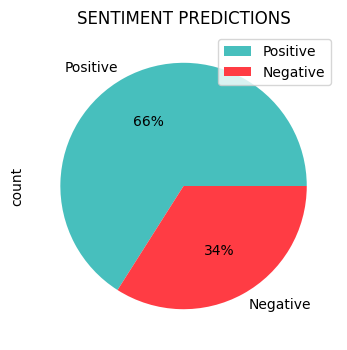

In [11]:
# Creating a tkinter GUI
window = Tk()
window.geometry("700x450")
window.title('Metacritic Sentiment Analyzer')

# Entry widget to write the metacritic link
entry = Entry(window, width = 90)
entry.place(x=45, y=15)

# Button widget to start scrapping
btn1 = Button(window, text='Enter', command=button_command)
btn1.place(x=600, y=10)

# Result labels
rcount_label1 = Label(window, text='Total Reviews:')
rcount_label1.place(x=60, y=70)
rcount_label1.config(font=("Courier", 10))
rcount_label2 = Label(window, text="")
rcount_label2.place(x=75, y=90)
rcount_label2.config(font=("Courier", 10), fg='#ff3c44')

overall_label1 = Label(window, text='Overall Ratings: ')
overall_label1.place(x=220, y=70)
overall_label1.config(font=("Courier", 10))
overall_label2 = Label(window, text="")
overall_label2.place(x=215, y=90)
overall_label2.config(font=("Courier", 30))

btn2 = Button(window, text='Download Reviews', command=lambda:review.to_csv('downloaded_reviews.csv', index = False))
btn2.place(x=570, y=400)

window.mainloop()